## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Reading data 

In [2]:
def read_data(filename):
    with open(filename, 'r') as f:
        data = f.readlines()
        data = [line.strip() for line in data]           # Remove '\n'
        data = [line.split(',') for line in data]        # Split by ','
        data = [list(map(int, line)) for line in data]   # Convert list of string to list of int
    
    return data

## Genetic Algorithm

In [3]:
class GA():
    def __init__(self, data):
        self.data = data
        self.size = len(data)
        self.population = []
        self.population_fitness = []
        self.best_by_iteration = []
        self.mean_by_iteration = []
        
    def fitness(self, solution):
        if len(solution) != self.size:
            raise ValueError("Solution size shoud be equal the number of the problem. Solution size: {}. Problem size: {}"
                            .format(len(solution), self.size))
        
        data_ordered = [self.data[i] for i in solution]
        
        maquina1 = 0 
        maquina2 = 0 
        maquina3 = 0 
        for data in data_ordered:
            maquina1 += data[0]
            maquina2 += data[1] + max(0, maquina1 - maquina2)
            maquina3 += data[2] + max(0, maquina2 - maquina3)
        return maquina3
    
    def remove_values_from_list(self, the_list, val):
        return [value for value in the_list if value != val]

    def crossover(self, ind1, ind2):  # Order crossover
        size = min(len(ind1), len(ind2))  #self.size
        
        # randomly select a substring in parent 1
        start = np.random.randint(0, size)
        end = np.random.randint(start, size)
        child = [-1] * size
        child2 = [-1] * size
        # copy the substring to offspring
        for i in range(start, end+1):
            child[i] = ind1[i]
            child2[i] = ind2[i]
        temp1, temp2 = ind1.copy(), ind2.copy()
        for i in range(0, size):
            # find and delete substring elements in parent 2
            if (temp2[i] in child):
                temp2[i] = -1
            if (temp1[i] in child2):
                temp1[i] = -1

        popped2 = self.remove_values_from_list(temp2, -1)
        popped1 = self.remove_values_from_list(temp1, -1)
        k = 0
        u = 0
        for i in range(0, size):
            if (child[i] == -1):
                child[i] = popped2[k]
                k = k + 1
            if (child2[i] == -1):
                child2[i] = popped1[u]
                u = u + 1
        #print("Popped: ", popped1, popped2)
        #print("Child: ",child, child2)
        #print("Type: ", type(child))
        return np.array(child), np.array(child2)

    def swap(self, solution):  # swap mutation
        # picks 2 random indexes in solution
        indexes = list(range(0, self.size))
        np.random.shuffle(indexes)
        swapIndex1, swapIndex2 = indexes[0], indexes[1]
        # swap the chosen elements
        temp = solution[swapIndex1]
        solution[swapIndex1] = solution[swapIndex2]
        solution[swapIndex2] = temp
        
    
    def tournament(self, k=5):
        if k > len(self.population):
            raise ValueError('K value for tournament should be smaller than population size. K: {}, Population size: {}'
                            .format(k, len(self.population)))
        
        chosen_indexes = set()
        while len(chosen_indexes) < k:
            #print("k: ", k, "  chosen_indexes: ", chosen_indexes)
            chosen_indexes.add(np.random.randint(len(self.population)))
        #print("set: ", chosen_indexes)
        chosen_indexes = list(chosen_indexes)
            
        best = chosen_indexes[0]
        for i in chosen_indexes:
            if self.population_fitness[i] < self.population_fitness[best]:
                best = i
        
        #print("Population fitness ", self.population_fitness)
        #print("Best: ", best)
        return best
     
    def run(self, population_size=20, crossover_probability=0.8, mutation_probability=0.6, k=5, number_of_iterations=1):
        
        ## Inicialize population
        self.best_by_iteration = []
        self.mean_by_iteration = []
        self.population = []
        self.population_fitness = []
        permutations = list(range(self.size))
        for _ in range(population_size):
            self.population.append(np.random.permutation(permutations))
            self.population_fitness.append(self.fitness(self.population[-1]))
    
        ## Main loop 
        for iteration in range(number_of_iterations):
            parent1_ind = self.tournament(k)
            parent2_ind = self.tournament(k)
            parent1 = self.population[parent1_ind]
            parent2 = self.population[parent2_ind]
            # Crossover
            if np.random.rand() < crossover_probability:
                child1, child2 = self.crossover(parent1, parent2)
            else:
                child1 = parent1
                child2 = parent2
            # Mutation
            if np.random.rand() < mutation_probability:
                self.swap(child1)  # Mutation is inline , returns None
                self.swap(child2)
            # Evaluate
            child1_fitness = self.fitness(child1)
            child2_fitness = self.fitness(child2)
            # Select individuals based on elitism 
            if child1_fitness < self.population_fitness[parent1_ind]:
                self.population[parent1_ind] = child1
                self.population_fitness[parent1_ind] = child1_fitness
            if child2_fitness < self.population_fitness[parent2_ind]:
                self.population[parent2_ind] = child2
                self.population_fitness[parent2_ind] = child2_fitness
            
            ## Save metrics
            self.best_by_iteration.append(min(self.population_fitness))
            self.mean_by_iteration.append(np.mean(self.population_fitness))
            
            ## Steadily increase trounament k to improve exploitation as the method evolves
            ## TO DO
            
        #print("Final best is ", min(self.population_fitness))
        return self.best_by_iteration, self.mean_by_iteration
        
    
    def test_parameters_set(self, population_size=20, crossover_probability=0.8, mutation_probability=0.6, k=5, number_of_iterations=1, repetitions=10, directory='plots3'):
        best_list = []
        mean_list = []
        for repetition in range(repetitions):
            best, mean = self.run(population_size, crossover_probability, mutation_probability, k, number_of_iterations)
            best_list.append(best)
            mean_list.append(mean)
            
        final_best = np.mean(best_list, axis=0)  # Take average performance 
        final_mean = np.mean(mean_list, axis=0) 
        
        ## Plotting 
        plt.figure(figsize=(12,6), dpi=100)
        plt.subplot(121)
        plt.suptitle('Parameters: Population size: {}, Crossover probability: {}, Mutation probability: {}, k: {}, Max iterations = {}'.format(population_size, crossover_probability, mutation_probability, k, number_of_iterations))
        plt.title("Best fitness")
        plt.plot(final_best)
        plt.ylabel("Fitness")
        plt.xlabel("Iterations")

        plt.subplot(122)
        plt.title("Mean fitness")
        plt.plot(final_mean)
        plt.ylabel("Fitness")
        plt.xlabel("Iterations")
        plt.subplots_adjust(hspace=8, wspace=0.4)

        OUTNAME = 'population{}_crossover{}_mutation{}_k{}_iterations{}'.format(population_size, crossover_probability, mutation_probability, k, number_of_iterations)
        plt.savefig(directory + '/' + OUTNAME+'.png')

## Problem 1

In [4]:
filename = 'entrada_3.txt'
data = read_data(filename)
p1 = GA(data)

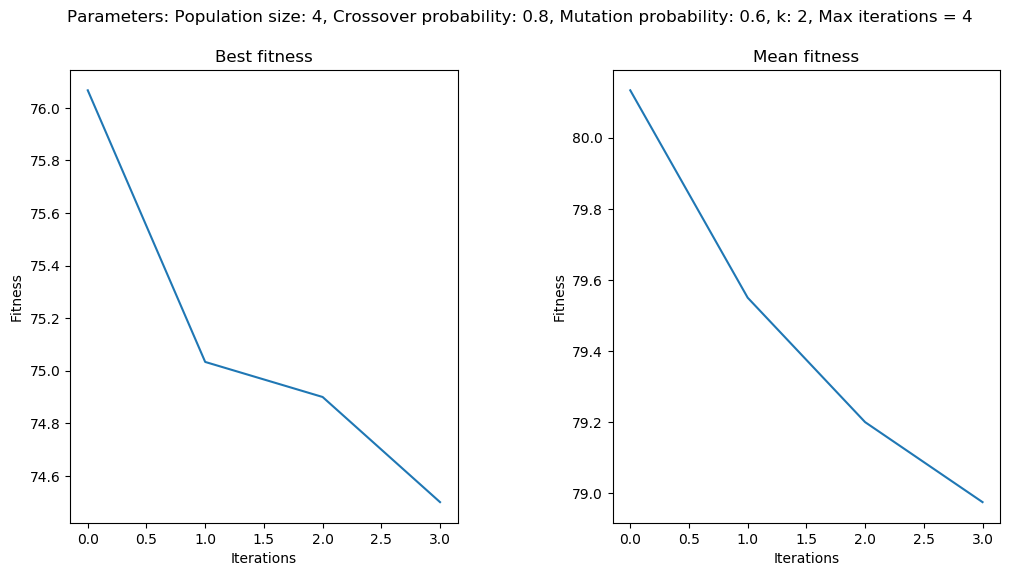

In [5]:
population_size=4
crossover_probability=0.8
mutation_probability=0.6
k=2
number_of_iterations=4
repetitions = 30
directory = 'plots3'
p1.test_parameters_set(population_size, crossover_probability, mutation_probability, k, number_of_iterations, repetitions, directory)

## Problem 2

In [6]:
filename = 'entrada_10.txt'
data = read_data(filename)
p2 = GA(data)

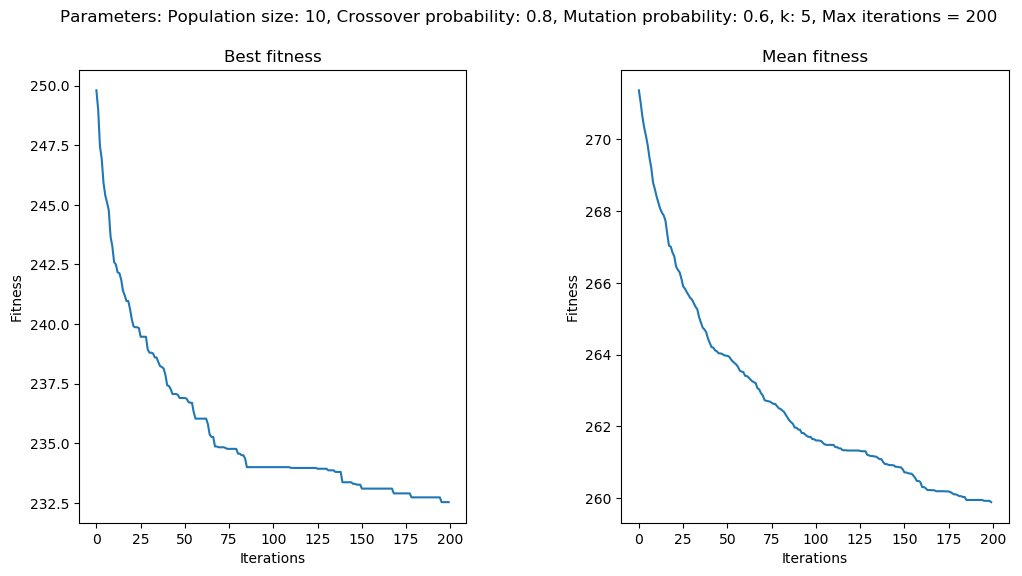

In [20]:
population_size=10
crossover_probability=0.8
mutation_probability=0.6
k=5
number_of_iterations=200
repetitions = 30
directory = 'plots10'
p2.test_parameters_set(population_size, crossover_probability, mutation_probability, k, number_of_iterations, repetitions, directory)

In [21]:
print(p2.population)
print(p2.population_fitness)
print("Best: ", min(p2.population_fitness), p2.population[np.argmin(p2.population_fitness)])

[array([3, 0, 1, 8, 2, 5, 9, 6, 7, 4]), array([4, 3, 5, 0, 6, 7, 1, 2, 9, 8]), array([0, 8, 1, 4, 3, 2, 7, 9, 6, 5]), array([4, 6, 1, 3, 9, 7, 0, 8, 2, 5]), array([2, 6, 0, 8, 1, 3, 7, 9, 4, 5]), array([3, 8, 6, 5, 9, 1, 7, 0, 4, 2]), array([0, 6, 7, 1, 4, 3, 8, 2, 9, 5]), array([3, 8, 1, 6, 0, 4, 7, 5, 2, 9]), array([4, 3, 6, 9, 0, 2, 5, 1, 7, 8]), array([4, 0, 2, 3, 1, 6, 5, 9, 7, 8])]
[278, 255, 233, 280, 304, 238, 289, 297, 228, 238]
Best:  228 [4 3 6 9 0 2 5 1 7 8]


## Problem 3

In [22]:
filename = 'entrada_25.txt'
data = read_data(filename)
p3 = GA(data)

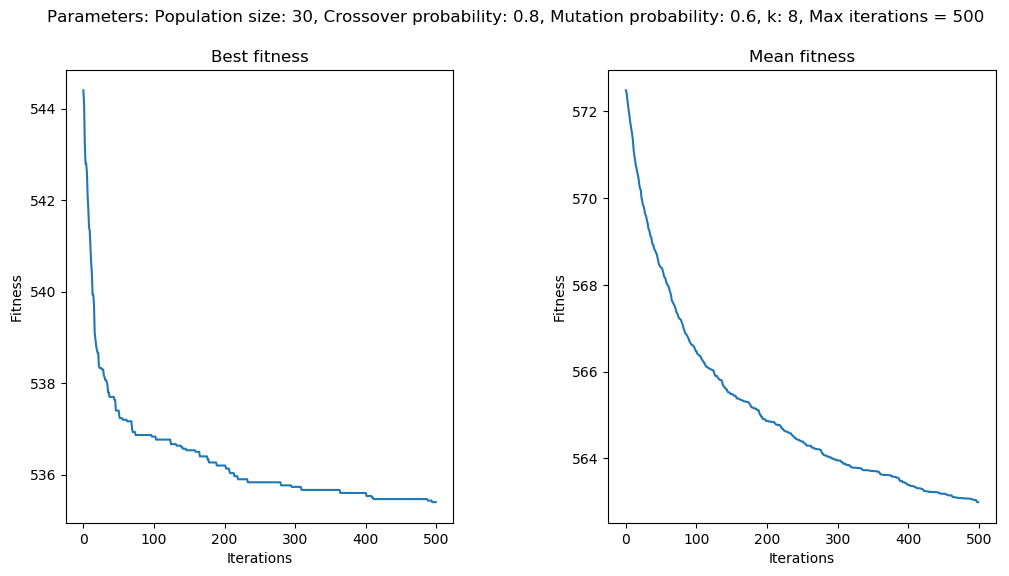

In [26]:
population_size=30
crossover_probability=0.8
mutation_probability=0.6
k=8
number_of_iterations=500
repetitions = 30
directory = 'plots25'
p3.test_parameters_set(population_size, crossover_probability, mutation_probability, k, number_of_iterations, repetitions, directory)

In [28]:
print("Best: ", min(p3.population_fitness), p3.population[np.argmin(p3.population_fitness)])

Best:  535 [20 19 24 16  4  5  7  9 15  0 21 17 18  2 23 13 10 22 12 11  6  1  3  8
 14]
